In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
# Statsmodels for ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Keras/TensorFlow for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def load_and_preprocess_data():
    """
    Load and preprocess the weather and crop price datasets.
    """
   
    # Load datasets (same as original implementation)
    weather_data = pd.read_csv('formatted_weather.csv')
    crop_prices = {
        'potato': pd.read_csv('potatoprice.csv'),
    }
   
    # Preprocess dates
    weather_data['Price Date'] = pd.to_datetime(weather_data['Price Date'], format='%d-%b-%y', dayfirst=True)
    for crop_name, crop_df in crop_prices.items():
        crop_prices[crop_name]['Price Date'] = pd.to_datetime(crop_df['Price Date'], format='%d-%b-%y', dayfirst=True)
    
    return weather_data, crop_prices

In [ ]:
def hybrid_arima_lstm_model(data, crop_name, n_timesteps=30, forecast_horizon=2):
    """
    Hybrid ARIMA-LSTM model for time series forecasting
    
    Parameters:
    - data: DataFrame with time series data
    - crop_name: Name of the crop for logging
    - n_timesteps: Number of time steps for LSTM input sequence
    - forecast_horizon: Number of steps to forecast
    
    Returns:
    - Predictions and model details
    """
    try:
        # Prepare price data
        prices = data['Modal Price (Rs./Quintal)']
        
        # Fit ARIMA model
        arima_model = ARIMA(prices, order=(5,1,2))
        arima_results = arima_model.fit()
        
        # Get ARIMA residuals
        arima_residuals = prices - arima_results.fittedvalues
        
        # Prepare LSTM input
        scaler = MinMaxScaler()
        scaled_residuals = scaler.fit_transform(arima_residuals.dropna().values.reshape(-1, 1))  # Drop NaNs
        
        # Create sequences for LSTM
        X, y = [], []
        for i in range(n_timesteps, len(scaled_residuals)):
            X.append(scaled_residuals[i-n_timesteps:i])
            y.append(scaled_residuals[i])
        
        X = np.array(X)
        y = np.array(y)
        
        if X.shape[0] == 0:
            raise ValueError("Not enough data for LSTM training. Reduce n_timesteps or check data size.")
        
        # Reshape for LSTM [samples, time steps, features]
        X = X.reshape((X.shape[0], X.shape[1], 1))
        
        # Split data
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        
        # Build LSTM model
        lstm_model = Sequential([
            LSTM(50, activation='relu', input_shape=(n_timesteps, 1), return_sequences=True),
            Dropout(0.2),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        
        # Train LSTM
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lstm_model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # 1. ARIMA forecast
        arima_forecast = arima_results.forecast(steps=forecast_horizon)
        
        # 2. LSTM residual forecast
        last_sequence = scaled_residuals[-n_timesteps:].reshape(1, n_timesteps, 1)
        lstm_residuals = []
        for _ in range(forecast_horizon):
            next_residual = lstm_model.predict(last_sequence, verbose=0)
            lstm_residuals.append(next_residual[0,0])
            last_sequence = np.roll(last_sequence, -1, axis=1)
            last_sequence[0, -1] = next_residual[0,0]
        
        # Inverse transform LSTM residuals
        lstm_residuals = scaler.inverse_transform(np.array(lstm_residuals).reshape(-1, 1))
        
        # Ensure ARIMA and LSTM forecast arrays have the same shape before adding
        if len(arima_forecast) != len(lstm_residuals.flatten()):
            raise ValueError(f"Mismatch in forecast lengths: ARIMA ({len(arima_forecast)}) vs LSTM ({len(lstm_residuals.flatten())})")
        
        # Combine ARIMA and LSTM forecasts
        combined_forecast = arima_forecast + lstm_residuals.flatten()
        
        # Evaluation
        mse = mean_squared_error(y_test, lstm_model.predict(X_test, verbose=0))
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, lstm_model.predict(X_test, verbose=0))
        
        # Print metrics
        print(f"\nMetrics for {crop_name}:")
        print(f"LSTM MSE: {mse:.5f}")
        print(f"LSTM RMSE: {rmse:.5f}")
        print(f"LSTM MAE: {mae:.5f}\n")
        
        # Print forecasted prices
        print(f"Predicted Prices (Hybrid ARIMA-LSTM Forecast) for {crop_name}:")
        print(combined_forecast)
        
        # Plot results
        plt.figure(figsize=(15, 8))
        plt.plot(prices.values, label='Actual')
        plt.plot(range(len(prices), len(prices) + forecast_horizon), 
                 combined_forecast, label='Hybrid Forecast', color='red')
        plt.title(f'{crop_name.capitalize()} Price Hybrid Forecast')
        plt.xlabel('Time Steps')
        plt.ylabel('Price (Rs./Quintal)')
        plt.legend()
        plt.show()
        
        return {
            'arima_model': arima_results,
            'lstm_model': lstm_model,
            'forecast': combined_forecast,
            'metrics': {
                'mse': mse,
                'rmse': rmse,
                'mae': mae
            }
        }
    
    except Exception as e:
        print(f"Error processing {crop_name}: {e}")
        return None



Processing potato...


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



📊 Metrics for potato:
LSTM MSE: 0.00091
LSTM RMSE: 0.03016
LSTM MAE: 0.01057

📈 Predicted Prices (Hybrid ARIMA-LSTM Forecast) for potato:
1510    4071.805234
1511    4288.564129
Name: predicted_mean, dtype: float64


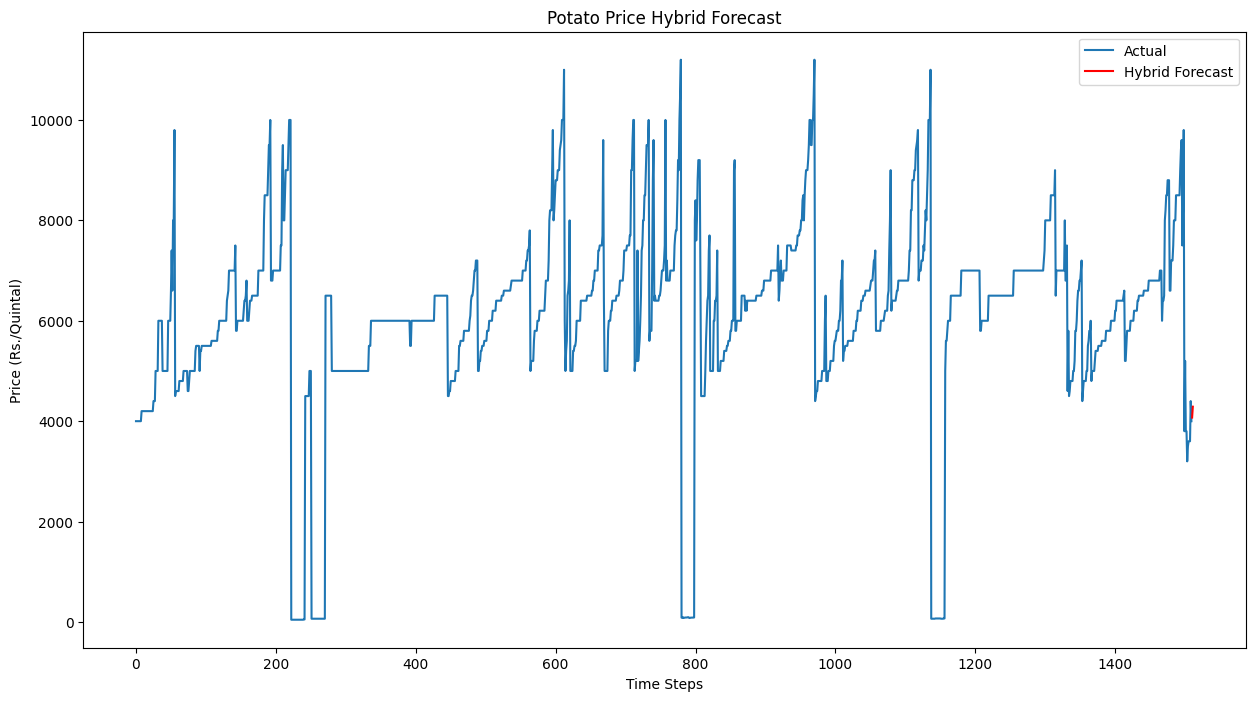

In [12]:
def main():
    # Load data
    weather_data, crop_prices = load_and_preprocess_data()
    
    # Results storage
    results = {}
    
    # Process each crop
    for crop_name, price_data in crop_prices.items():
        print(f"\nProcessing {crop_name}...")
        
        # Merge with weather if needed
        try:
            # You might want to add weather features similar to original implementation
            model_results = hybrid_arima_lstm_model(price_data, crop_name)
            
            if model_results:
                results[crop_name] = model_results
        
        except Exception as e:
            print(f"Error in processing {crop_name}: {e}")
            continue
    
    return results

if __name__ == "__main__":
    results = main()